In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from functools import partial
from math import log2
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize
import seaborn as sns
import torch
from torch import tensor, Tensor
from typing import Any, Literal

import block_formats.experiments as E
import block_formats.analysis as A
import block_formats.quantisation as Q
import block_formats.fit as F

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
model = E.RequantisableModel.load("meta-llama/Llama-3.2-1B", DEVICE, torch.bfloat16)
params = {k: v.detach() for k, v in model.model.named_parameters() if v.ndim == 2}
data = E.Dataset.load_wikitext2(model.model, sequence_length=256, batch_size=16, kl_topk=128, sequence_limit=16)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


## RMS moment-matching isn't optimal

It looks like Normal often needs greater scale (to cope with tails), while Student-t or Laplace sometimes need smaller scale (if they have excessive tails).

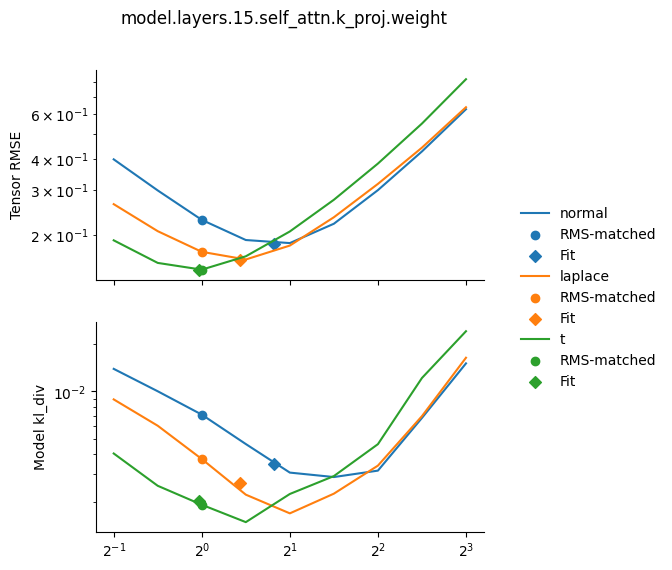

In [ ]:
bits = 4

model.reset()
key = "model.layers.15.self_attn.k_proj.weight"
x = params[key].float().flatten()
scales = tensor(2).pow(torch.arange(-1, 3+.0001, .5))

fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(5, 6), sharex=True)

# Note - Student-t uses potentially different df when `fit()`
for family, color in zip(["normal", "laplace", "t"], sns.color_palette()):

    def evaluate(element_format: Q.TensorFormat) -> Tensor:
        return Q.qrmse_norm(Q.LinearScalingFormat(element_format, Q.FP32, (None,), "rms"), x)

    def show(fmt: Q.ScaledFormat, name: str, marker: str, ax: matplotlib.axes.Axes) -> None:
        ax.scatter([fmt.scale], [evaluate(fmt).item()], label=name, color=color, marker=marker)

    unscaled_fmt = dict(normal=Q.crd_normal, laplace=Q.crd_laplace, t=partial(Q.crd_t, df=5))[family](bits)
    fit_fmt = F.Scaled(bits, family, Q.FP32, (None,), "rms", compressor=None).fit(x)

    errors = torch.stack([evaluate(Q.ScaledFormat(unscaled_fmt, s)) for s in scales])
    ax0.plot(scales.cpu(), errors.cpu(), label=family, color=color)
    show(Q.ScaledFormat(unscaled_fmt, 1), "RMS-matched", "o", ax0)
    show(fit_fmt.element_format, "Fit", "D", ax0)

    def evaluate(element_format: Q.TensorFormat) -> Tensor:
        model.reset()
        p = model.model.state_dict()[key]
        model.model.state_dict()[key][...] = Q.LinearScalingFormat(element_format, Q.FP32, (None, None), "rms").quantise(p)
        return data.evaluate(model.model)["kl_div"].mean()

    errors = torch.stack([evaluate(Q.ScaledFormat(unscaled_fmt, s)) for s in scales])
    ax1.plot(scales.cpu(), errors.cpu(), color=color)
    show(Q.ScaledFormat(unscaled_fmt, 1), "RMS-matched", "o", ax1)
    show(fit_fmt.element_format, "Fit", "D", ax1)

for ax in [ax0, ax1]:
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
ax0.set_ylabel("Tensor RMSE")
ax1.set_ylabel("Model kl_div")
fig.suptitle(key)
fig.legend(*ax0.get_legend_handles_labels(), bbox_to_anchor=(0.95, 0.5), loc="center left");

## Fit quantiser example

In [5]:
model.reset()
key = "model.layers.0.self_attn.q_proj.weight"
x = params[key].float()
bits = 4
block_size = 64

print(key)
for compression in [None, "optimal"]:
    for block_size, scaling in [(None, "rms"), (64, "signmax")]:
        for element_family in ["int", "fp", "normal", "laplace", "t", "lloyd_max"]:
            if compression and element_family != "int":
                continue
            fmt = F.Scaled(bits, element_family, Q.BFLOAT16, (1, block_size), scaling, compression).fit(x)
            title = f"{'compress:' + compression + ' ' if compression else ''}{element_family}, {scaling}"
            print(f"{title:>30}: {fmt.count_bits_tensor(x) / x.nelement():.1f} bpp, R = {Q.qrmse_norm(fmt, x).item():.3f}")
        print()

model.layers.0.self_attn.q_proj.weight
                      int, rms: 4.0 bpp, R = 0.126
                       fp, rms: 4.0 bpp, R = 0.121
                   normal, rms: 4.0 bpp, R = 0.112
                  laplace, rms: 4.0 bpp, R = 0.113
                        t, rms: 4.0 bpp, R = 0.111
                lloyd_max, rms: 4.0 bpp, R = 0.110

                  int, signmax: 4.2 bpp, R = 0.102
                   fp, signmax: 4.2 bpp, R = 0.107
               normal, signmax: 4.2 bpp, R = 0.093
              laplace, signmax: 4.2 bpp, R = 0.101
                    t, signmax: 4.2 bpp, R = 0.093
            lloyd_max, signmax: 4.2 bpp, R = 0.090

     compress:optimal int, rms: 4.0 bpp, R = 0.074

 compress:optimal int, signmax: 4.3 bpp, R = 0.074

